In [1]:
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

from datetime import datetime, timezone

### SQL settings

In [2]:
DBNAME = "fesa_test"
HOST = "140.181.85.66"
PORT = "54321"
USER = "fesa_tester"
PASSWORD = "save_bpm"

In [3]:
try:
    dbcon = psycopg2.connect("dbname="+DBNAME + " user=" + USER + " host=" + HOST + " port=" + PORT + " password=" + PASSWORD)
except Exception as e:
    print("Unable to connect to database")
    print(e)

crsr = dbcon.cursor()

### overview over shots for which all twelve BPMs recorded

In [4]:
def stamp2time(stamp):
    ts = stamp / 1e9
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S.%f')

In [27]:
def fetch_all_acquisitionStamp(crsr=crsr):
    stamps = dict()
    for i in range(1,13):
        bpm_name = "gs{:02d}dx".format(i)
        
        crsr.execute("SELECT acquisitionStamp FROM {} WHERE acqMode = 1;".format(bpm_name + "_acquisition"))
        
        stamps[bpm_name] = crsr.fetchall()
    
    return stamps

In [28]:
def consistent_acquisitionStamp(acquisitionStamps, time_threshold = 1e6):
    consistent_shots = list()  # store all shots for which all twelve BPMs recorded

    gs01dx_arr = np.array(acquisitionStamps["gs01dx"]).squeeze(axis=1)
    for stamp in gs01dx_arr:
        if stamp == 0:
            continue

        shot_stamps = np.zeros((12,), dtype=int)

        for i in range(2,13):
            bpm_name = "gs{:02d}dx".format(i)
            curStamps = np.array(acquisitionStamps[bpm_name]).squeeze(axis=1)

            # closest acquisition
            idx = np.abs(curStamps - stamp).argmin()

            if abs(stamp - curStamps[idx]) > 10:
                # nothing close
                break

            shot_stamps[i-1] = curStamps[idx]
        else:
            shot_stamps[0] = stamp
            consistent_shots.append(shot_stamps)

    consistent_shots = np.stack(consistent_shots)
    
    return consistent_shots

In [29]:
def get_shotOverview(time_threshold = 1e6):
    acquisitionStamps = fetch_all_acquisitionStamp()
    
    return consistent_acquisitionStamp(acquisitionStamps, time_threshold=time_threshold)

In [30]:
shotOverview = get_shotOverview(time_threshold = 1e6)

first_record = shotOverview[0][0]
last_record = shotOverview[-1][0]

stamp2time(first_record)

'2023-11-01 13:03:38.381300'

In [31]:
shotOverview.shape

(14, 12)

In [32]:
for row in range(shotOverview.shape[0]):
    print(np.allclose(shotOverview[row,:], shotOverview[row,0]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True


# Read BPM

In [14]:
date = "2023-11-1"

time = "13:03:45.0"

In [15]:
time_datetime = datetime.strptime(" ".join([date,time]), '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=timezone.utc)
stamp_given = int(time_datetime.timestamp() * 1e9)

# stamps_arr = np.array(stamps).squeeze(axis=1)
idx_closest_stamp = np.abs(shotOverview[:,0] - stamp_given).argmin()

In [16]:
idx_closest_stamp

1

###### selected cycle

In [17]:
display_stamp = shotOverview[idx_closest_stamp,0]

stamp2time(display_stamp)

'2023-11-01 13:03:44.461500'

# fetch beamPosition for acquisitionStamp

In [37]:
def bpmReadings_demasked(no_bpm: int, acquisitionStamp: int, crsr=crsr):
    statement = """
    SELECT
        processIndex, beamPosition, beamPosition_dim3_labels, processStartStamp
    FROM
        gs{:02d}dx_acquisition
    WHERE
        acquisitionStamp = %s
    ORDER BY
        processStartStamp
;
    """.format(no_bpm)
    
    crsr.execute(statement, [int(acquisitionStamp),])
    data = crsr.fetchall()
    
    assert len(data) > 0, "nothing selected"
    
    # flatten over all beamprocesses in this pattern
    x_raw, y_raw, time = list(), list(), list()
    for process in data:
        timepoints = len(process[2])
        time += process[2]
        
        assert 2*timepoints == len(process[1]), "mask assumption wrong"
        
        x = process[1][0:timepoints]
        y = process[1][timepoints:]
        
        x_raw += x
        y_raw += y
        
    return np.array(x_raw), np.array(y_raw), np.array(time)

In [73]:
def findKickTime(x_raw, y_raw, time, harmonic_number: int):
    ######## implement some criterion to locate kick
    
    ##### fake 
    l = 512
    kick_times = time[l:l+harmonic_number]

    # calculate revolution period
    Trev = time[l + harmonic_number] - time[l]
    
    return kick_times, Trev

### fetch

In [74]:
harmonic_number = 4

In [78]:
trajectory = np.empty((12,3,1024))  # bpm starting from 5, x/y/time, window length

for i, no_bpm in enumerate([5,6,7,8,9,10,11,12,1,2,3,4]):
    x_raw, y_raw, time = bpmReadings_demasked(no_bpm, display_stamp)
        
    if no_bpm == 5:
        kick_times, Trev = findKickTime(x_raw, y_raw, time, harmonic_number)
        print("found kick_times")
        print("Trev", Trev)
    
    print("\n", no_bpm)
    
    for no_bunch, kickTime in enumerate(kick_times):
        retarded_kickTime = kickTime + i * Trev/12
        assert retarded_kickTime >= kickTime
        
        kick_idx = np.abs(time - retarded_kickTime).argmin()
        
        print("minimum distance to kickTime", np.abs(time - kickTime).min())
        print("minimum distance to retarded_kickTime", np.abs(time - retarded_kickTime).min())
        print("diff", abs(time[kick_idx] - retarded_kickTime))
        
#         assert abs(time[kick_idx] - retarded_kickTime) < Trev/12, "kick_idx far away from kickTime"
#         assert np.abs(time - retarded_kickTime).min() < Trev/12, "kick_idx far away from kickTime"
        
        traj_mask = np.zeros(time.shape, dtype=bool)
        traj_mask[kick_idx::harmonic_number] = True
        
        trajectory[i,0,:] = x_raw[traj_mask][:trajectory.shape[2]]
        trajectory[i,1,:] = y_raw[traj_mask][:trajectory.shape[2]]
        trajectory[i,2,:] = time[traj_mask][:trajectory.shape[2]]

found kick_times
Trev 4992

 5
minimum distance to kickTime 0
minimum distance to retarded_kickTime 0.0
diff 0.0
minimum distance to kickTime 0
minimum distance to retarded_kickTime 0.0
diff 0.0
minimum distance to kickTime 0
minimum distance to retarded_kickTime 0.0
diff 0.0
minimum distance to kickTime 0
minimum distance to retarded_kickTime 0.0
diff 0.0

 6
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0

 7
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0
minimum distance to kickTime 4
minimum distance to retarded_kickTime 512.0
diff 512.0
minimum distance to kickTime 4


# debug

In [80]:
Trev / 12

416.0

In [82]:
np.diff(t1)

array([1248, 1248, 1248, ...,  564,  564,  564])

In [84]:
t2 - t1

array([4, 4, 4, ..., 4, 4, 4])

In [ ]:
dbcon.reset()

In [24]:
crsr.execute("""
    SELECT
    processIndex, beamPosition, beamPosition_dim3_labels, processStartStamp, acqMode
    FROM gs01dx_acquisition
    WHERE acquisitionStamp = %s;
    """, [int(shotOverview[idx_closest_stamp,0])]
            )

data = crsr.fetchall()
processIndex, beamPosition, beamPosition_dim3_labels, processStartStamp, acqMode = data[0]
acqMode

1

In [25]:
np.array(beamPosition).shape

(600000,)

In [26]:
np.array(beamPosition_dim3_labels).shape

(300000,)

In [100]:
crsr.execute("""
    SELECT
    processIndex, beamPosition, beamPosition_dim3_labels, processStartStamp, acqMode
    FROM gs02dx_acquisition
    WHERE acquisitionStamp = %s;
    """, [int(shotOverview[idx_closest_stamp,0])]
            )

data = crsr.fetchall()
_, beamPosition_2, beamPosition_dim3_labels_2, _, _ = data[0]
_

1

In [101]:
t1 = np.array(beamPosition_dim3_labels)
t2 = np.array(beamPosition_dim3_labels_2)

In [102]:
np.abs(t1 - t2).max()

4

In [103]:
t2[:5]

array([1698843824461507604, 1698843824461508852, 1698843824461510100,
       1698843824461511348, 1698843824461512604])

In [104]:
np.diff(kick_times)

array([1252, 1252, 1252])

In [105]:
756 * 4

3024

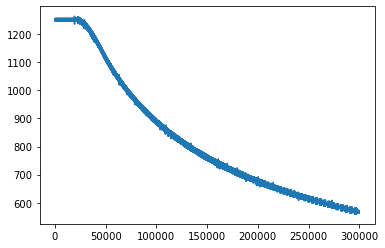

In [106]:
plt.plot(np.diff(t1))

In [107]:
np.corrcoef(beamPosition, beamPosition_2)

array([[1.        , 0.00185365],
       [0.00185365, 1.        ]])

In [21]:
crsr.execute("""
    SELECT
    acqMode
    FROM gs01dx_acquisition
    """)

In [22]:
acq = crsr.fetchall()

In [23]:
acq

[(2,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,),
 (1,)]

In [98]:
foo = np.arange(15)
np.corrcoef(foo, foo)

array([[1., 1.],
       [1., 1.]])